# A01: Signals and Sampling (Quick Version)

**Duration**: ~30 minutes  
**Prerequisites**: Basic Python, NumPy fundamentals

> 💡 **Quick Version**: This notebook imports pre-built functions from `src/signals.py` instead of defining them inline. For the full tutorial with step-by-step function implementations, see [A01_signals_and_sampling.ipynb](A01_signals_and_sampling.ipynb).

## Learning Objectives

By the end of this notebook, you will be able to:
- Understand the difference between continuous and discrete signals
- Apply the Nyquist-Shannon sampling theorem to determine appropriate sampling rates
- Predict aliasing artifacts when signals are undersampled
- Use the signal generation functions from `src/signals.py`

---

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Continuous vs Discrete Signals](#section-2-continuous-vs-discrete-signals)
3. [Sampling Rate and Temporal Resolution](#section-3-sampling-rate-and-temporal-resolution)
4. [The Nyquist-Shannon Theorem](#section-4-the-nyquist-shannon-theorem)
5. [Aliasing: When Sampling Goes Wrong](#section-5-aliasing-when-sampling-goes-wrong)
6. [Building Block Functions](#section-6-building-block-functions)
7. [Practical Considerations for EEG](#section-7-practical-considerations-for-eeg)
8. [Exercises](#section-8-hands-on-exercises)
9. [Summary](#summary)
10. [External Resources](#external-resources)
11. [Discussion Questions](#discussion-questions)

---

In [21]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.colors import COLORS
from src.plotting import configure_plots
from src.signals import (
    generate_time_vector,
    generate_sine_wave,
    generate_white_noise,
    generate_pink_noise,
    generate_composite_signal,
    compute_aliased_frequency,
)

# Apply plot configuration
configure_plots()

## Section 1: Introduction

Electroencephalography (EEG) measures the electrical activity of the brain as it unfolds continuously in time. The voltage fluctuations at each electrode reflect the summed activity of thousands of neurons, creating complex waveforms that carry information about cognitive processes, emotional states, and neural communication.

However, computers cannot store continuous signals. Instead, they capture discrete samples at regular intervals, converting the smooth, continuous reality into a sequence of numbers. This process of **sampling** is fundamental to all digital signal processing, and understanding it is essential for proper EEG analysis.

The quality of our analysis depends critically on how well these discrete samples represent the original continuous signal. Sample too slowly, and we lose important information. Sample too quickly, and we waste storage and computational resources. Finding the right balance requires understanding the relationship between sampling rate and the frequencies present in our signal.

Typical EEG systems sample at rates between 256 Hz and 1024 Hz. By the end of this notebook, you will understand why these values are chosen and what happens when sampling goes wrong.

## Section 2: Continuous vs Discrete Signals

A **continuous signal** is a mathematical idealization: a function defined at every point in time. If we could measure brain activity with infinite precision, we would obtain such a continuous signal, with a voltage value for every instant, no matter how small the time interval.

A **discrete signal**, in contrast, consists of values only at specific, regularly-spaced time points. This is what our computers actually store: a sequence of numbers, each representing the signal's value at one particular moment.

**Sampling** is the process of converting a continuous signal into a discrete one. We measure the signal at regular intervals, determined by the **sampling interval** $\Delta t$ (the time between consecutive samples). The **sampling rate** (or sampling frequency) $f_s$ is the number of samples per second:

$$f_s = \frac{1}{\Delta t}$$

For example, a sampling rate of 256 Hz means we take 256 measurements every second, with a sampling interval of approximately 3.9 milliseconds.

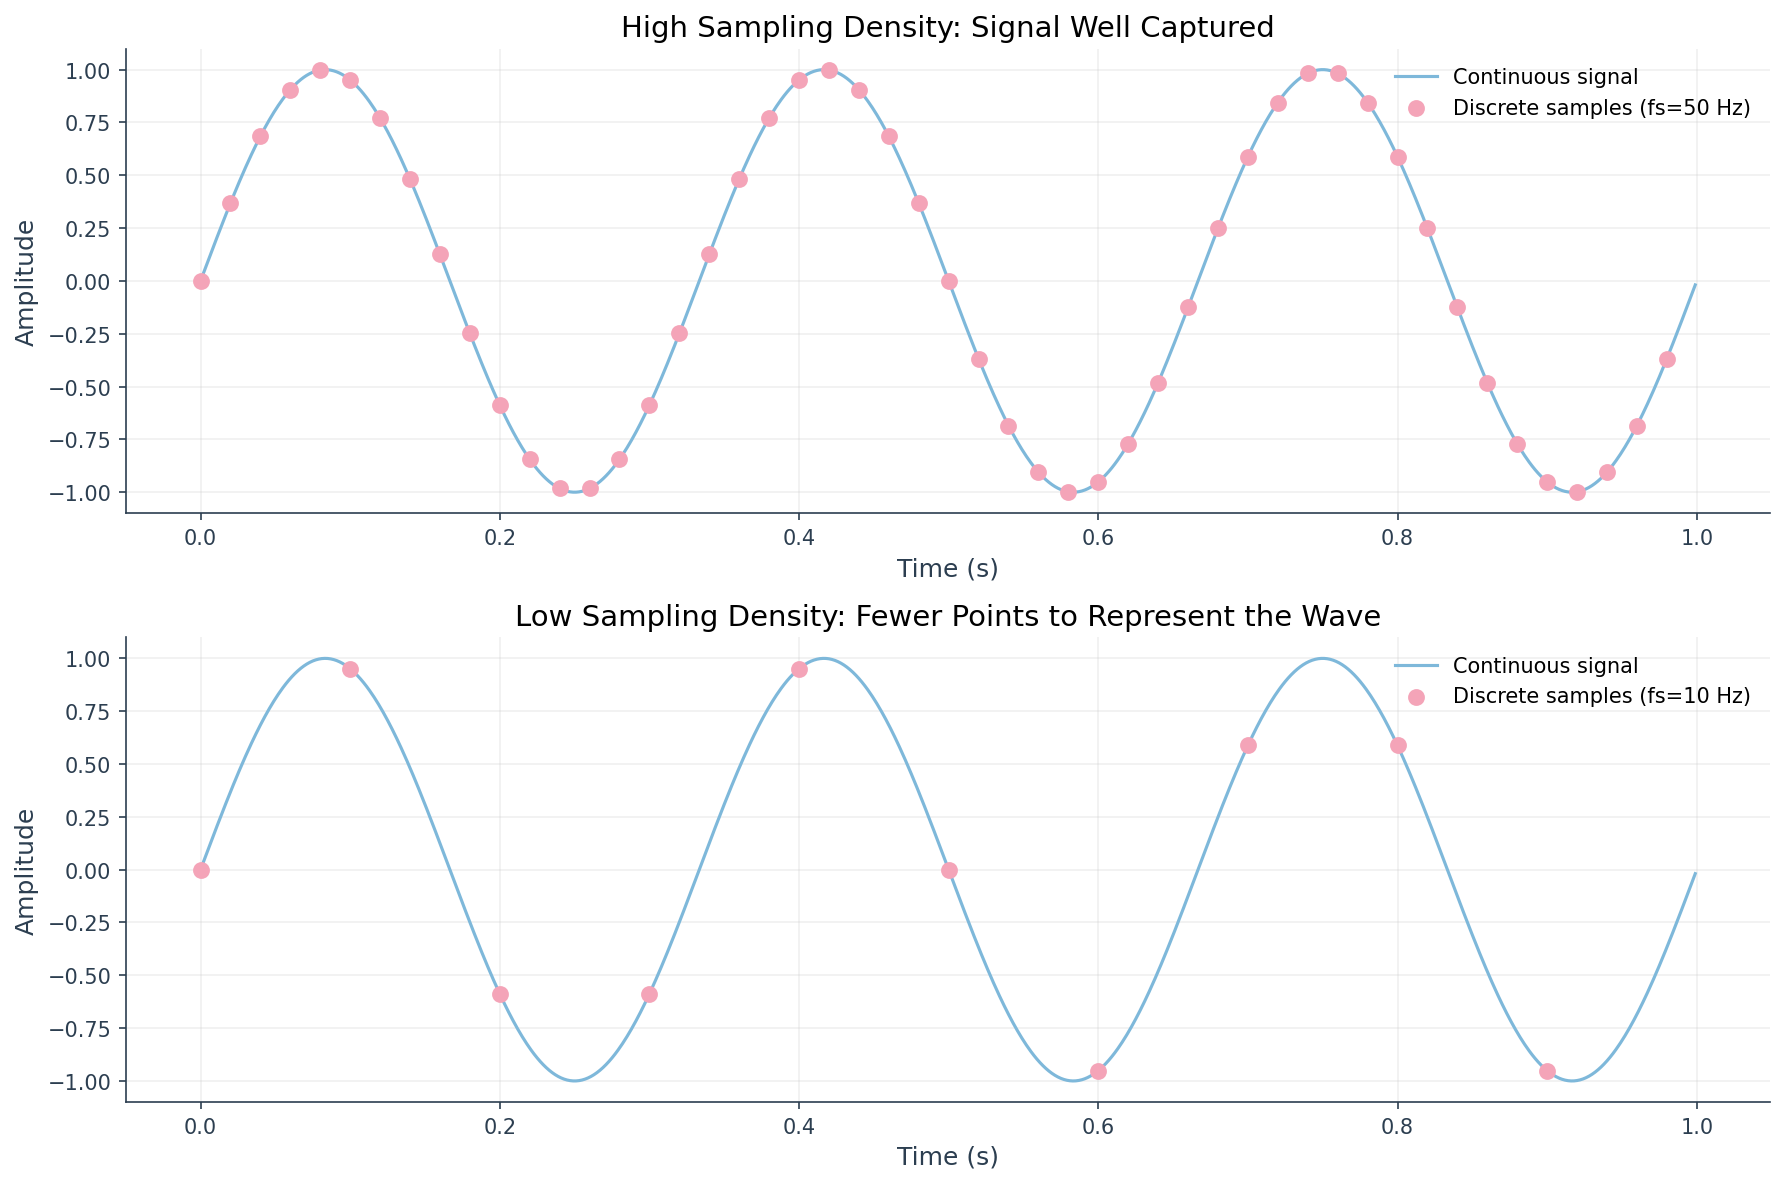

In [22]:
# Visualization 1: Continuous vs Discrete Signal
# We simulate a "continuous" signal using a very high sampling rate

duration = 1.0  # seconds
frequency = 3.0  # Hz

# "Continuous" signal (high sampling rate for smooth appearance)
fs_continuous = 1000  # Hz
t_continuous = generate_time_vector(duration, fs_continuous)
signal_continuous = generate_sine_wave(t_continuous, frequency)

# Discrete samples at different densities
fs_high = 50  # Hz - many samples
fs_low = 10   # Hz - few samples

t_high = generate_time_vector(duration, fs_high)
t_low = generate_time_vector(duration, fs_low)

signal_high = generate_sine_wave(t_high, frequency)
signal_low = generate_sine_wave(t_low, frequency)

# Create figure
fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=150)

# Top: High sampling rate
axes[0].plot(t_continuous, signal_continuous, color=COLORS["signal_1"], 
             linewidth=1.5, label="Continuous signal")
axes[0].scatter(t_high, signal_high, color=COLORS["signal_2"], s=50, 
                zorder=5, label=f"Discrete samples (fs={fs_high} Hz)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title("High Sampling Density: Signal Well Captured")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom: Low sampling rate
axes[1].plot(t_continuous, signal_continuous, color=COLORS["signal_1"], 
             linewidth=1.5, label="Continuous signal")
axes[1].scatter(t_low, signal_low, color=COLORS["signal_2"], s=50, 
                zorder=5, label=f"Discrete samples (fs={fs_low} Hz)")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Low Sampling Density: Fewer Points to Represent the Wave")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The figure above illustrates the sampling process. The smooth blue curve represents our idealized continuous signal, while the pink dots show the discrete samples that would be stored by a digital system.

Notice how with more samples (top panel), the discrete points trace out the wave shape quite accurately. With fewer samples (bottom panel), we still capture the general oscillation, but with less detail. The question becomes: how few samples can we use while still accurately representing the signal?

## Section 3: Sampling Rate and Temporal Resolution

The sampling rate directly determines two important properties of our digital signal:

1. **Temporal resolution**: Higher sampling rates capture finer temporal details. At 1000 Hz, we can distinguish events 1 ms apart; at 100 Hz, our resolution drops to 10 ms.

2. **Frequency representation**: The sampling rate limits the highest frequency we can accurately represent. This is the crucial insight that leads to the Nyquist theorem.

For EEG analysis, we care about neural oscillations in specific frequency bands:
- Delta (1-4 Hz): deep sleep
- Theta (4-8 Hz): memory, navigation
- Alpha (8-13 Hz): relaxed wakefulness
- Beta (13-30 Hz): active thinking
- Gamma (30-100+ Hz): perception, consciousness

Since the highest frequency of typical interest is around 100 Hz (gamma), a sampling rate of 256 Hz is often sufficient for most EEG research. But why exactly 256? The answer lies in the Nyquist theorem.

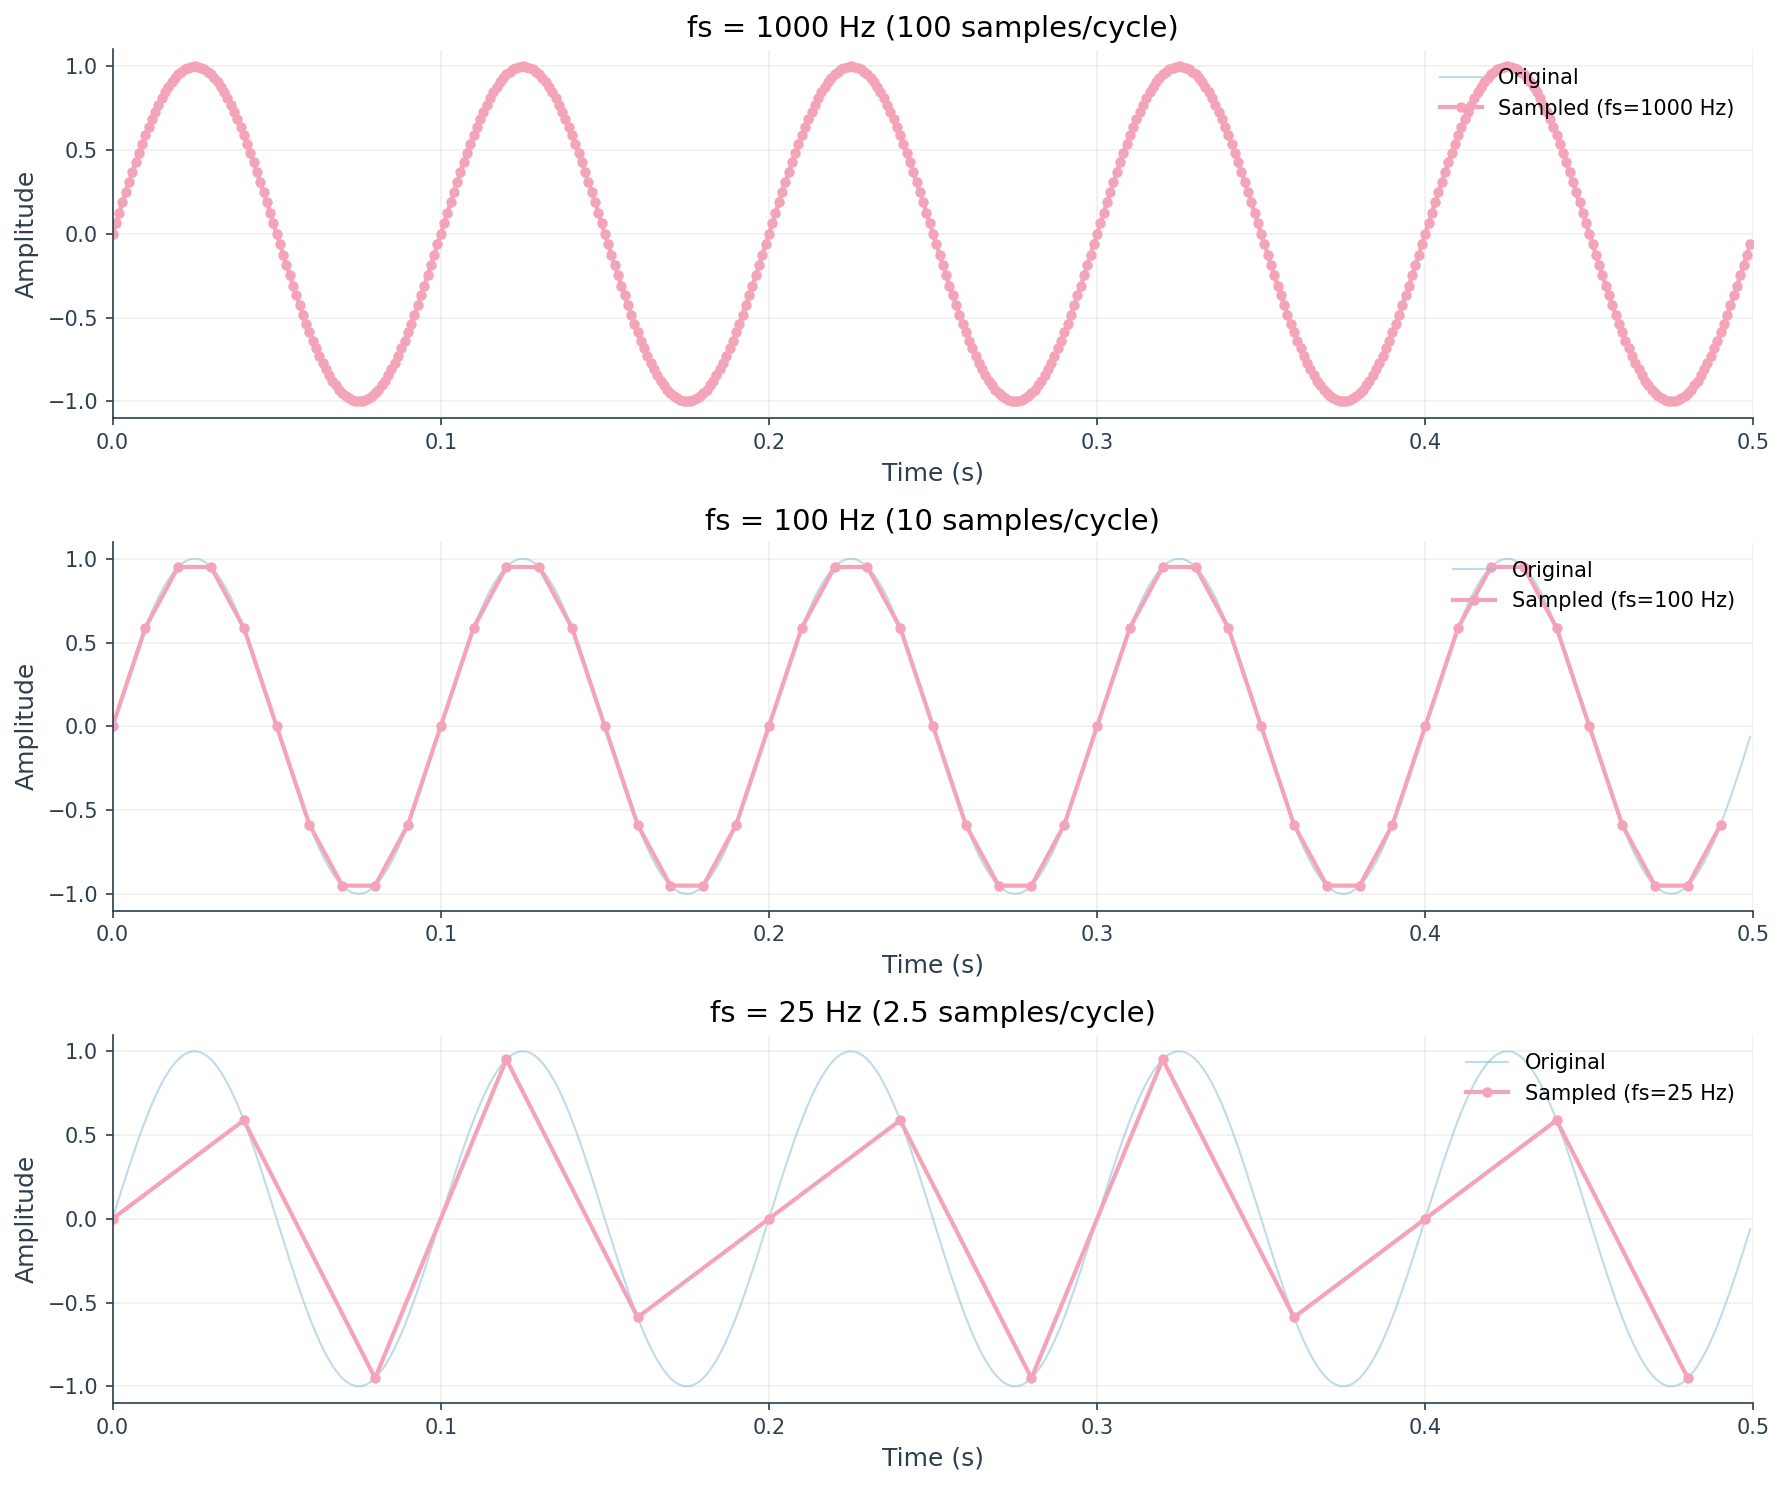

In [23]:
# Visualization 2: Same signal at different sampling rates

duration = 0.5  # seconds
frequency = 10.0  # Hz

# Reference "continuous" signal
t_ref = generate_time_vector(duration, 1000)
signal_ref = generate_sine_wave(t_ref, frequency)

# Three different sampling rates
sampling_rates = [1000, 100, 25]
titles = [
    f"fs = 1000 Hz (100 samples/cycle)",
    f"fs = 100 Hz (10 samples/cycle)",
    f"fs = 25 Hz (2.5 samples/cycle)",
]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), dpi=150)

for ax, fs, title in zip(axes, sampling_rates, titles):
    t = generate_time_vector(duration, fs)
    signal = generate_sine_wave(t, frequency)
    
    # Plot reference
    ax.plot(t_ref, signal_ref, color=COLORS["signal_1"], linewidth=1, 
            alpha=0.5, label="Original")
    # Plot sampled version
    ax.plot(t, signal, color=COLORS["signal_2"], linewidth=2, 
            marker="o", markersize=4, label=f"Sampled (fs={fs} Hz)")
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, duration)

plt.tight_layout()
plt.show()

The visualization shows a 10 Hz sine wave sampled at three different rates. At 1000 Hz, we have 100 samples per cycle, and the reconstruction is nearly perfect. At 100 Hz, we have 10 samples per cycle, which still captures the waveform well. At 25 Hz, we have only 2.5 samples per cycle, and while we can still see oscillation, the shape is becoming distorted.

This brings us to a fundamental question: what is the minimum sampling rate needed to accurately capture a signal of a given frequency?

## Section 4: The Nyquist Theorem

The **Nyquist-Shannon sampling theorem** provides the answer to our question. It states:

> To accurately represent a signal containing frequency $f$, we must sample at a rate $f_s > 2f$.

The frequency $f_N = f_s / 2$ is called the **Nyquist frequency**. It represents the highest frequency that can be accurately captured at a given sampling rate.

The intuition is straightforward: to capture an oscillation, we need at least two samples per cycle, one near the peak and one near the trough. With fewer than two samples per cycle, we cannot distinguish the oscillation from slower waves or even from a constant signal.

**Examples**:
- At $f_s$ = 256 Hz, the Nyquist frequency is 128 Hz. We can accurately capture any frequency up to 128 Hz.
- To capture gamma oscillations at 80 Hz, we need $f_s$ > 160 Hz.
- A 10 Hz alpha wave requires $f_s$ > 20 Hz at minimum.

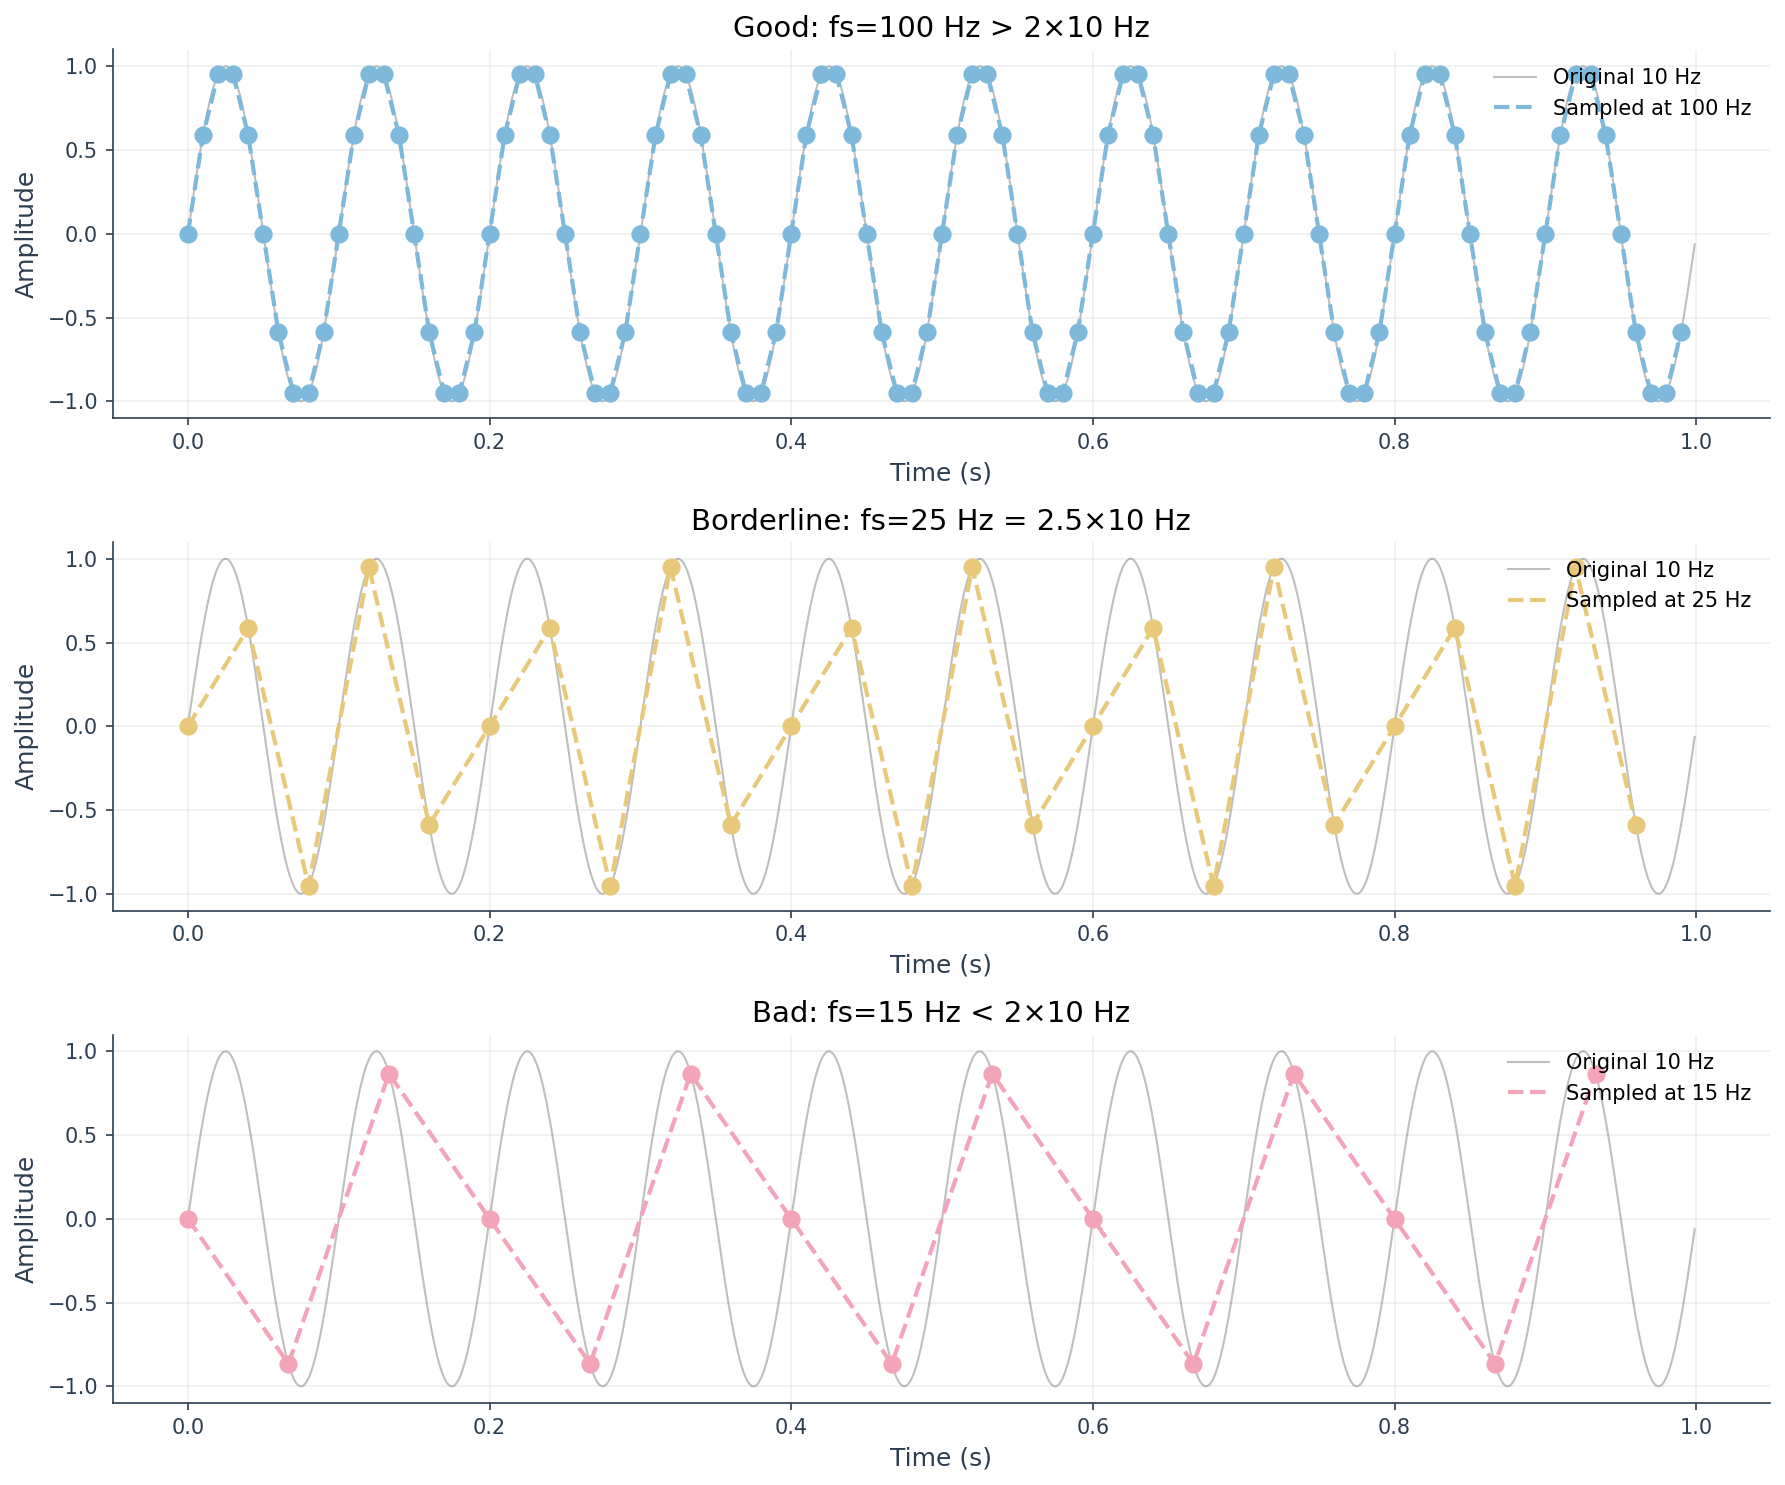

In [24]:
# Visualization 3: Nyquist theorem demonstration

duration = 1.0
frequency = 10.0  # Hz - our target signal

# Reference signal
t_ref = generate_time_vector(duration, 1000)
signal_ref = generate_sine_wave(t_ref, frequency)

# Three sampling scenarios
scenarios = [
    (100, "Good: fs=100 Hz > 2×10 Hz", COLORS["signal_1"]),
    (25, "Borderline: fs=25 Hz = 2.5×10 Hz", COLORS["signal_4"]),
    (15, "Bad: fs=15 Hz < 2×10 Hz", COLORS["signal_2"]),
]

fig, axes = plt.subplots(3, 1, figsize=(12, 10), dpi=150)

for ax, (fs, title, color) in zip(axes, scenarios):
    t = generate_time_vector(duration, fs)
    signal = generate_sine_wave(t, frequency)
    
    # Reference
    ax.plot(t_ref, signal_ref, color="gray", linewidth=1, alpha=0.5, 
            label="Original 10 Hz")
    # Samples and reconstruction
    ax.scatter(t, signal, color=color, s=60, zorder=5)
    ax.plot(t, signal, color=color, linewidth=2, linestyle="--", 
            label=f"Sampled at {fs} Hz")
    
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.legend(loc="upper right")
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The top panel shows adequate sampling: 100 Hz gives us 10 samples per cycle of our 10 Hz signal. The middle panel shows borderline sampling: 25 Hz gives 2.5 samples per cycle, which is just above the Nyquist limit. The bottom panel shows inadequate sampling: 15 Hz gives only 1.5 samples per cycle, violating the Nyquist theorem.

Notice how in the bottom panel, the samples no longer trace out the original 10 Hz wave. Instead, they suggest a different, slower oscillation. This phenomenon is called **aliasing**.

### [Optional Deep Dive] Mathematical Basis

The Nyquist-Shannon sampling theorem has a rigorous mathematical foundation. In its complete form, it states that a band-limited signal (one containing no frequencies above some maximum $f_{max}$) can be perfectly reconstructed from its samples if:

$$f_s > 2 f_{max}$$

The reconstruction is achieved through **sinc interpolation**:

$$x(t) = \sum_{n=-\infty}^{\infty} x[n] \cdot \text{sinc}\left(\frac{t - nT_s}{T_s}\right)$$

where $T_s = 1/f_s$ is the sampling period and $\text{sinc}(x) = \sin(\pi x)/(\pi x)$.

This theorem tells us that no information is lost when we sample at more than twice the highest frequency, and the original continuous signal can be perfectly recovered. In practice, we cannot achieve perfect reconstruction due to finite signal duration and numerical precision, but the theorem guides our choice of sampling rate.

## Section 5: Aliasing

When the Nyquist theorem is violated (when we sample a frequency $f$ at a rate $f_s < 2f$), something remarkable and dangerous happens: the high frequency appears as a lower frequency in our sampled data. This phenomenon is called **aliasing**.

The aliased frequency can be computed as:

$$f_{aliased} = |f - k \cdot f_s|$$

where $k$ is the integer that makes $f_{aliased}$ fall below the Nyquist frequency.

For example, a 40 Hz signal sampled at 50 Hz will appear as:
$$f_{aliased} = |40 - 1 \times 50| = 10 \text{ Hz}$$

This is dangerous because the aliased signal is indistinguishable from a true 10 Hz signal. We have no way of knowing, from the sampled data alone, whether we are looking at a real 10 Hz oscillation or an aliased 40 Hz artifact.

In [25]:
# Test the aliasing function
test_cases = [
    (40, 50, 10),   # 40 Hz sampled at 50 Hz -> 10 Hz
    (60, 50, 10),   # 60 Hz sampled at 50 Hz -> 10 Hz
    (90, 100, 10),  # 90 Hz sampled at 100 Hz -> 10 Hz
    (10, 100, 10),  # 10 Hz sampled at 100 Hz -> 10 Hz (no aliasing)
]

print("Aliasing examples:")
print("-" * 50)
for true_f, fs, expected in test_cases:
    aliased = compute_aliased_frequency(true_f, fs)
    print(f"{true_f:3.0f} Hz sampled at {fs:3.0f} Hz -> {aliased:5.1f} Hz")

Aliasing examples:
--------------------------------------------------
 40 Hz sampled at  50 Hz ->  10.0 Hz
 60 Hz sampled at  50 Hz ->  10.0 Hz
 90 Hz sampled at 100 Hz ->  10.0 Hz
 10 Hz sampled at 100 Hz ->  10.0 Hz


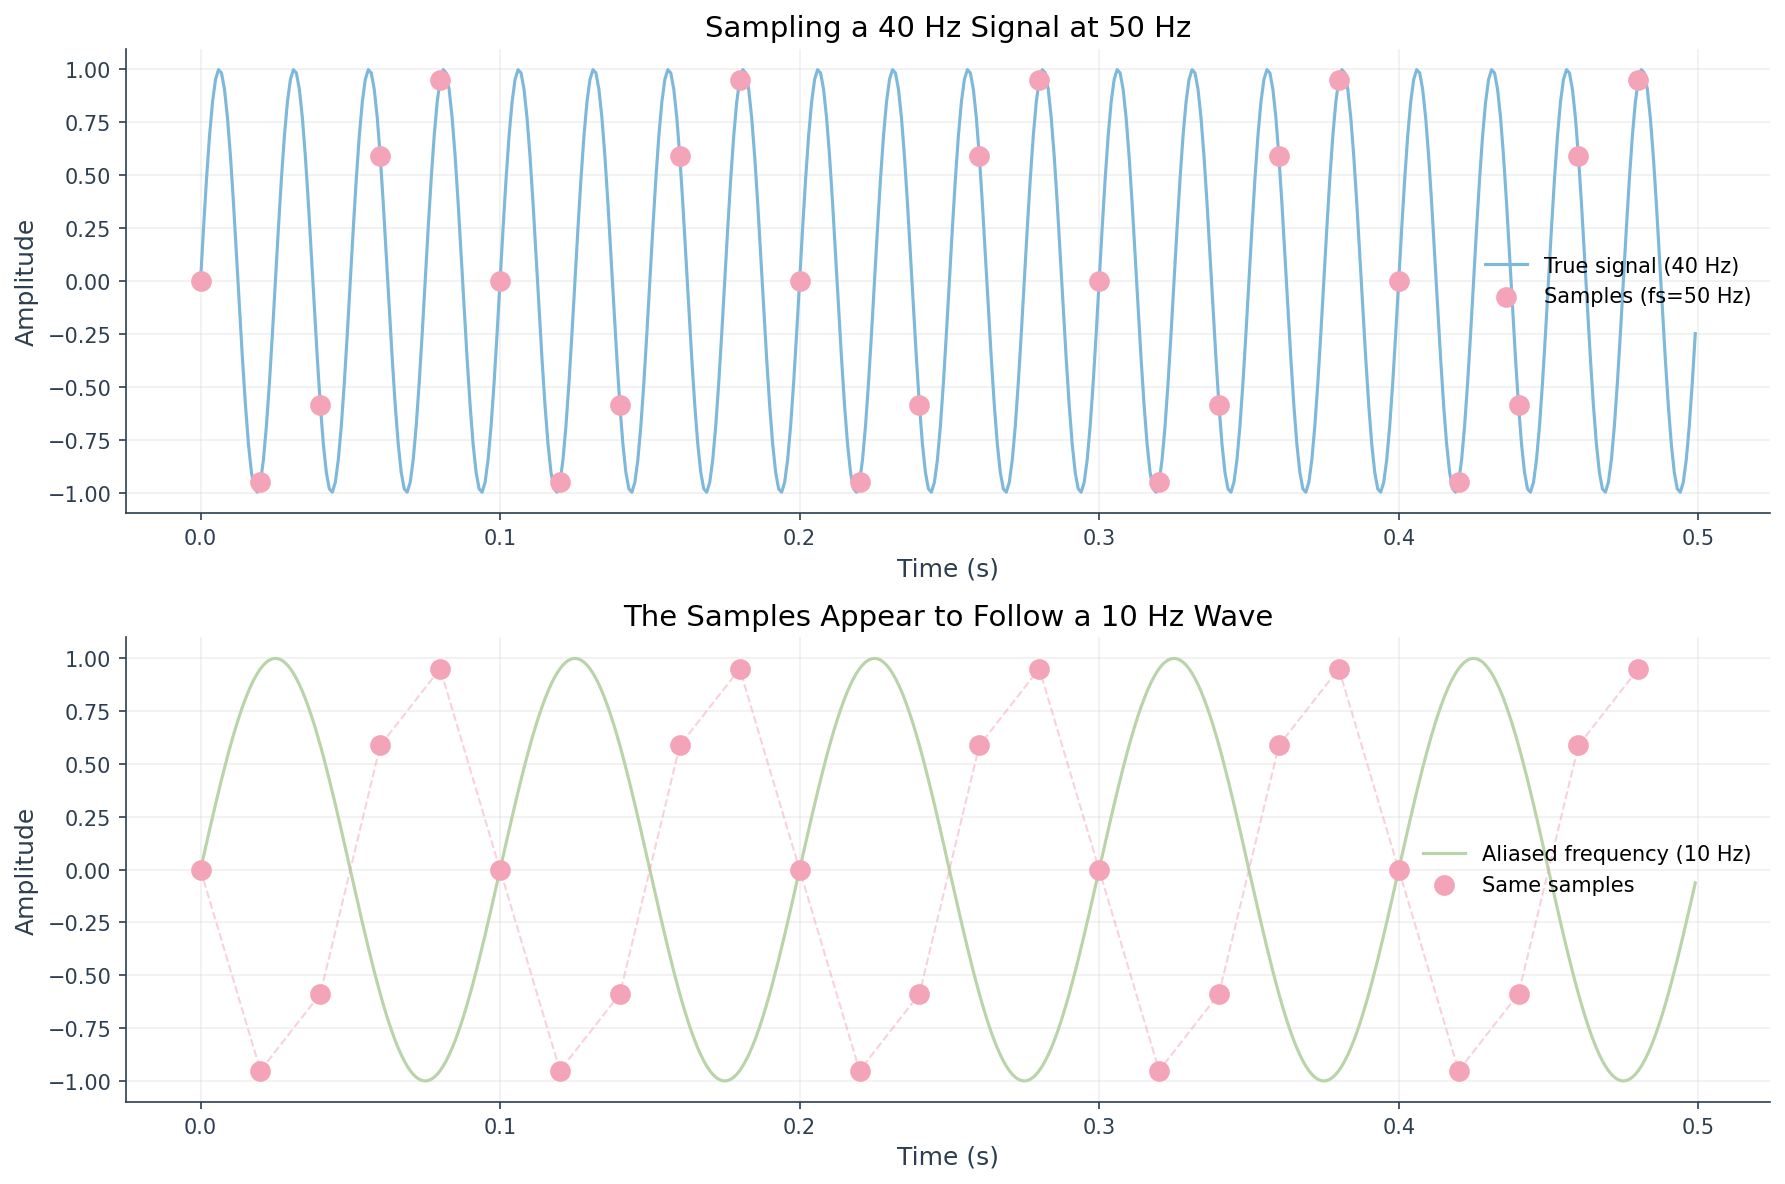

In [26]:
# Visualization 4: Aliasing example

duration = 0.5
true_frequency = 40.0  # Hz
fs_low = 50.0  # Hz - below Nyquist for 40 Hz
aliased_frequency = compute_aliased_frequency(true_frequency, fs_low)

# High-resolution reference signals
t_ref = generate_time_vector(duration, 1000)
signal_true = generate_sine_wave(t_ref, true_frequency)
signal_aliased_ref = generate_sine_wave(t_ref, aliased_frequency)

# Sampled signal
t_sampled = generate_time_vector(duration, fs_low)
signal_sampled = generate_sine_wave(t_sampled, true_frequency)

fig, axes = plt.subplots(2, 1, figsize=(12, 8), dpi=150)

# Top: Original signal and samples
axes[0].plot(t_ref, signal_true, color=COLORS["signal_1"], linewidth=1.5, 
             label=f"True signal ({true_frequency:.0f} Hz)")
axes[0].scatter(t_sampled, signal_sampled, color=COLORS["signal_2"], s=80, 
                zorder=5, label=f"Samples (fs={fs_low:.0f} Hz)")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Sampling a {true_frequency:.0f} Hz Signal at {fs_low:.0f} Hz")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom: Aliased interpretation
axes[1].plot(t_ref, signal_aliased_ref, color=COLORS["signal_3"], linewidth=1.5, 
             label=f"Aliased frequency ({aliased_frequency:.0f} Hz)")
axes[1].scatter(t_sampled, signal_sampled, color=COLORS["signal_2"], s=80, 
                zorder=5, label="Same samples")
axes[1].plot(t_sampled, signal_sampled, color=COLORS["signal_2"], linewidth=1, 
             linestyle="--", alpha=0.5)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title(f"The Samples Appear to Follow a {aliased_frequency:.0f} Hz Wave")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The top panel shows a true 40 Hz signal being sampled at only 50 Hz. The bottom panel reveals the problem: those same sample points fall perfectly on a 10 Hz sine wave. From the sampled data alone, we cannot distinguish between these two possibilities. The 40 Hz signal has been "aliased" to 10 Hz.

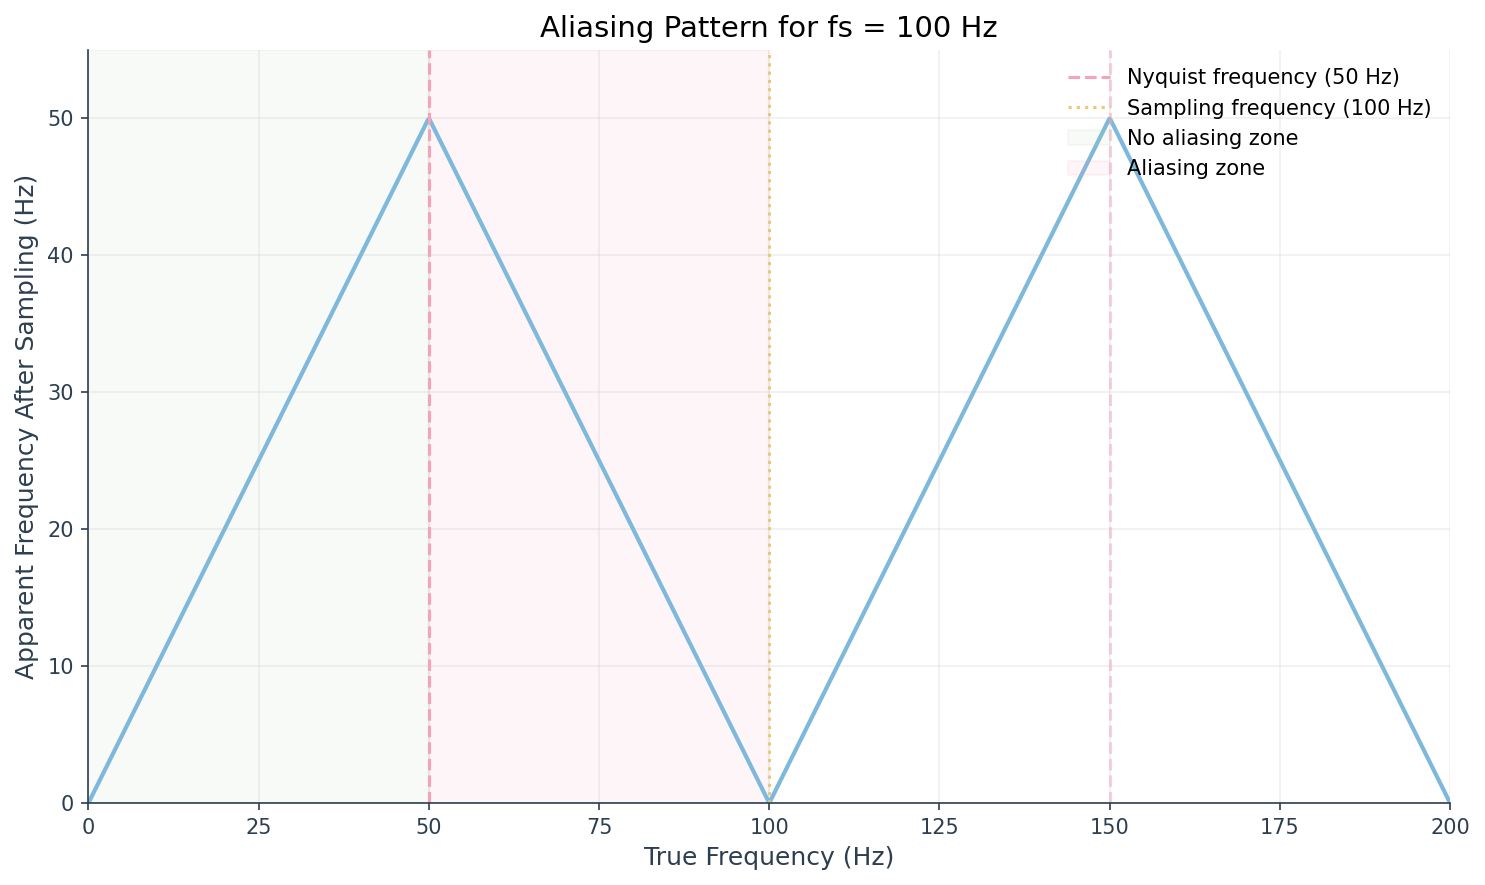

In [27]:
# Visualization 5: Aliasing zones

fs = 100  # Hz
nyquist = fs / 2

# Compute aliased frequencies for a range of true frequencies
true_frequencies = np.linspace(0, 200, 1000)
aliased_frequencies = np.array([compute_aliased_frequency(f, fs) for f in true_frequencies])

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

# Plot aliased frequency vs true frequency
ax.plot(true_frequencies, aliased_frequencies, color=COLORS["signal_1"], linewidth=2)

# Mark Nyquist frequency
ax.axvline(x=nyquist, color=COLORS["signal_2"], linestyle="--", linewidth=1.5, 
           label=f"Nyquist frequency ({nyquist:.0f} Hz)")
ax.axvline(x=fs, color=COLORS["signal_4"], linestyle=":", linewidth=1.5, 
           label=f"Sampling frequency ({fs:.0f} Hz)")
ax.axvline(x=fs + nyquist, color=COLORS["signal_2"], linestyle="--", linewidth=1.5, alpha=0.5)

# Shade aliasing zones
ax.axvspan(0, nyquist, alpha=0.1, color=COLORS["signal_3"], label="No aliasing zone")
ax.axvspan(nyquist, fs, alpha=0.1, color=COLORS["signal_2"], label="Aliasing zone")

ax.set_xlabel("True Frequency (Hz)")
ax.set_ylabel("Apparent Frequency After Sampling (Hz)")
ax.set_title(f"Aliasing Pattern for fs = {fs} Hz")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
ax.set_xlim(0, 200)
ax.set_ylim(0, nyquist + 5)

plt.tight_layout()
plt.show()

This figure shows how frequencies "fold" back when they exceed the Nyquist limit. Within the green zone (0 to 50 Hz), frequencies appear as themselves. Above the Nyquist frequency, they fold back: 60 Hz appears as 40 Hz, 70 Hz as 30 Hz, and so on. The pattern repeats at multiples of the sampling frequency.

This sawtooth pattern is why aliasing is sometimes called "frequency folding". Any frequency above Nyquist gets folded back into the representable range, masquerading as a lower frequency.

## Section 6: Signal Generation Functions

Throughout this workshop, we use synthetic signals to test our algorithms and build intuition. The signal generation functions are available in `src/signals.py`:

- `generate_time_vector(duration, fs)` — Create time arrays
- `generate_sine_wave(t, frequency, amplitude, phase)` — Pure oscillations
- `generate_white_noise(n_samples, amplitude, seed)` — Random fluctuations (flat spectrum)
- `generate_pink_noise(n_samples, amplitude, seed)` — 1/f noise (resembles real EEG)
- `generate_composite_signal(t, frequencies, amplitudes, phases)` — Multiple frequencies combined

Let's see them in action:

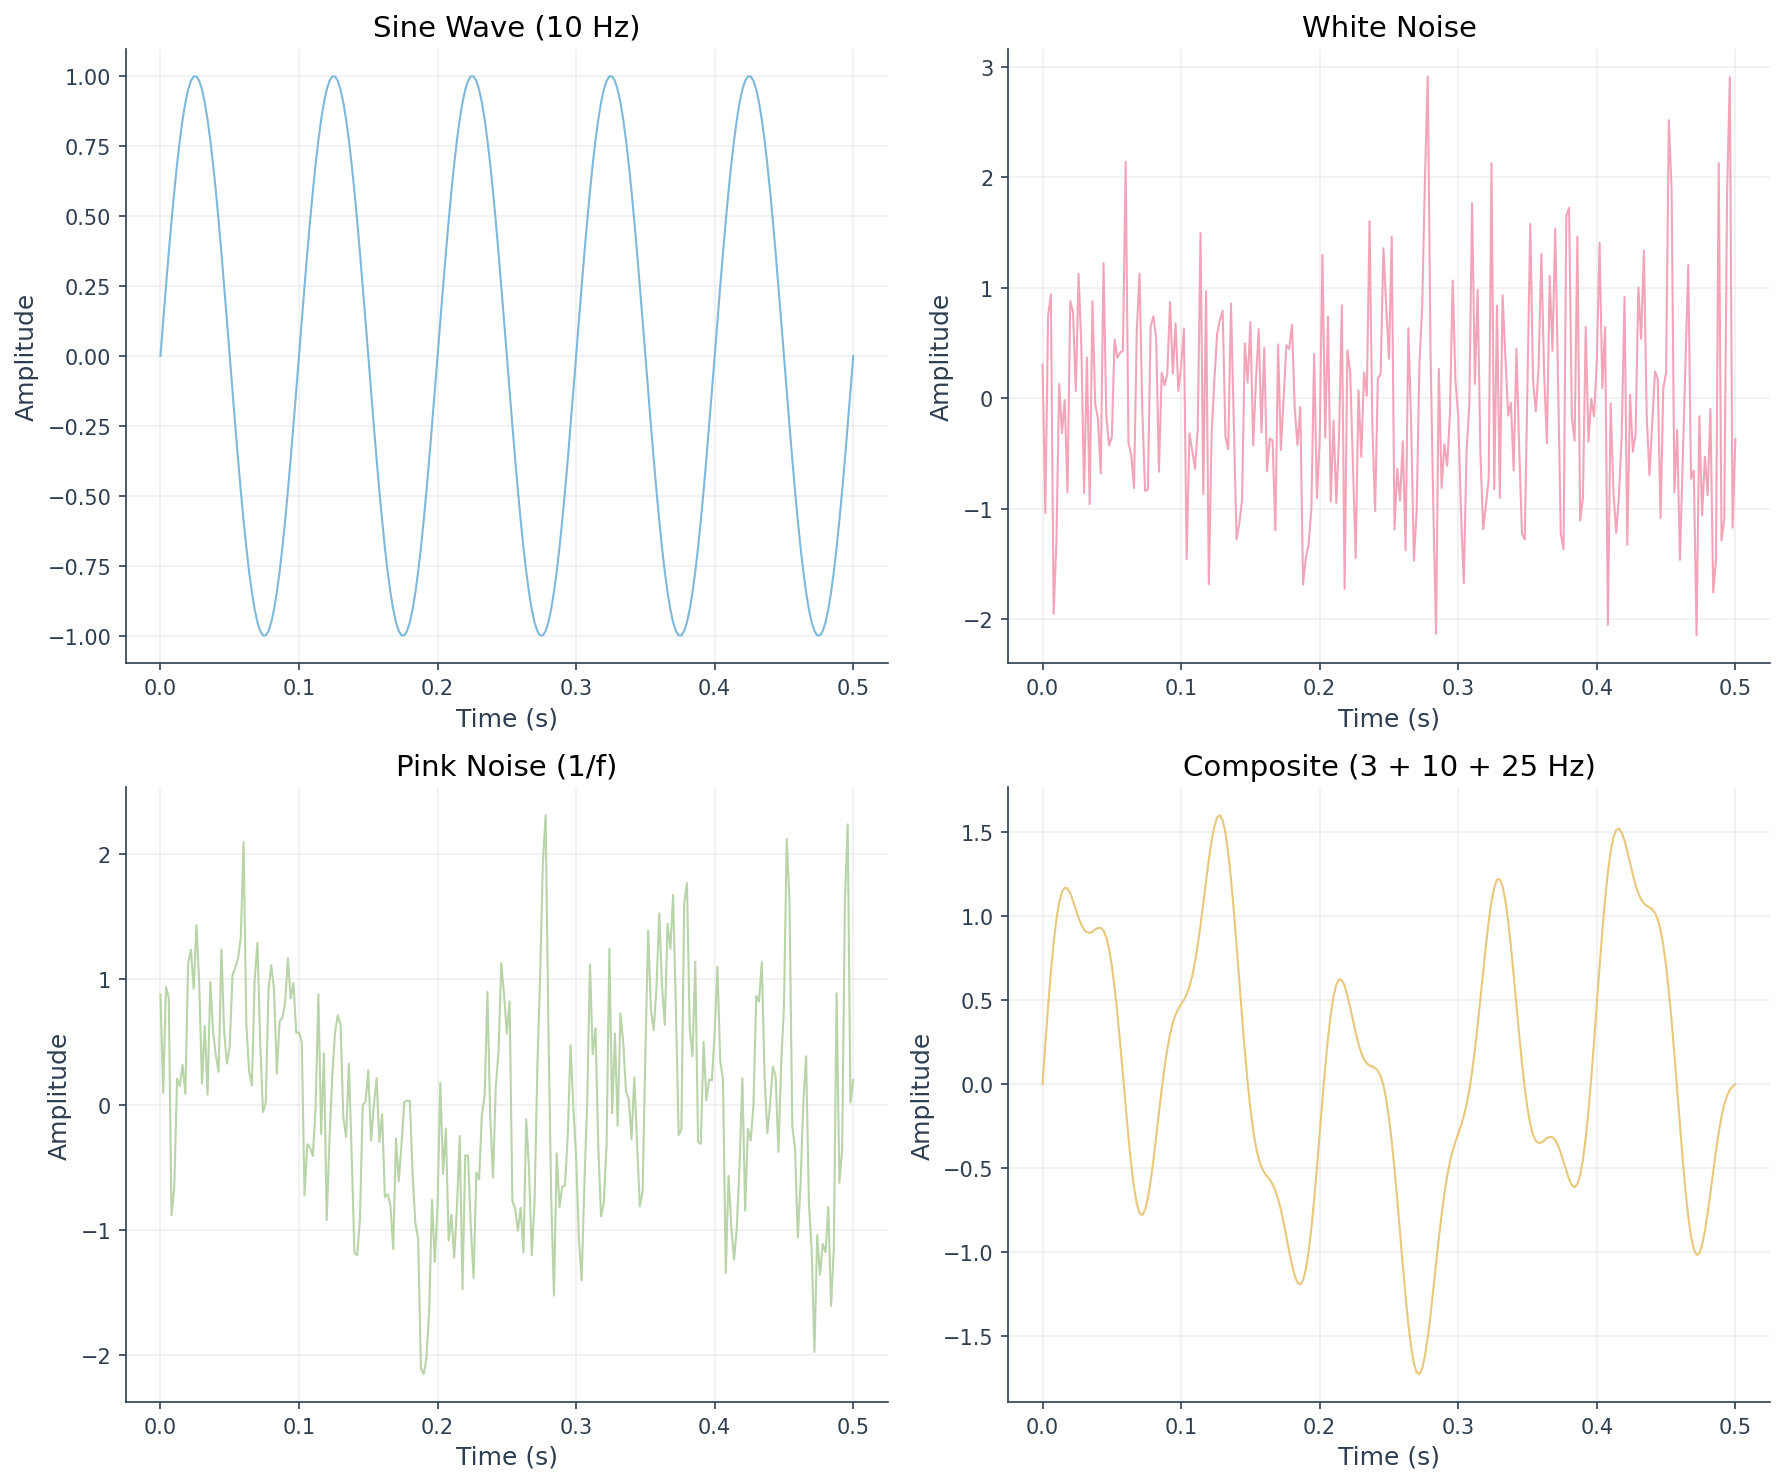

In [28]:
# Visualization 6: Signal types

duration = 2.0
fs = 500  # Hz
t = generate_time_vector(duration, fs)
n_samples = len(t)

# Generate different signal types
sine_signal = generate_sine_wave(t, frequency=10, amplitude=1.0)
white_signal = generate_white_noise(n_samples, amplitude=1.0, seed=42)
pink_signal = generate_pink_noise(n_samples, amplitude=1.0, seed=42)
composite_signal = generate_composite_signal(
    t, 
    frequencies=[3, 10, 25], 
    amplitudes=[0.5, 1.0, 0.3]
)

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)

signals = [
    (sine_signal, "Sine Wave (10 Hz)", COLORS["signal_1"]),
    (white_signal, "White Noise", COLORS["signal_2"]),
    (pink_signal, "Pink Noise (1/f)", COLORS["signal_3"]),
    (composite_signal, "Composite (3 + 10 + 25 Hz)", COLORS["signal_4"]),
]

for ax, (signal, title, color) in zip(axes.flat, signals):
    # Only show first 0.5 seconds for clarity
    mask = t <= 0.5
    ax.plot(t[mask], signal[mask], color=color, linewidth=1)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The four panels show our building blocks:
- **Sine wave**: A pure oscillation at a single frequency
- **White noise**: Random fluctuations that look "spiky" because all frequencies contribute equally
- **Pink noise**: Smoother random fluctuations dominated by low frequencies, more similar to real EEG
- **Composite signal**: Multiple frequencies combined, showing the complex waveforms we see in real data

These functions will be used throughout the workshop to create test signals with known properties.

## Section 7: Practical Considerations for EEG

Now that we understand the theory, let us consider how it applies to real EEG recording.

### Anti-Aliasing Filters

EEG amplifiers include **anti-aliasing filters** (low-pass filters) that remove high frequencies before digitization. If the system samples at 256 Hz, a hardware filter removes frequencies above ~100 Hz before sampling. This prevents muscle artifacts and electrical noise from aliasing into the EEG frequency range.

### Oversampling

Many modern systems deliberately **oversample**, recording at higher rates than strictly necessary. This provides:
- Better anti-aliasing filter performance
- Flexibility to downsample later
- Cleaner high-frequency content (gamma band)

### Downsampling

If you only need frequencies below 50 Hz, you can **downsample** from 1024 Hz to 256 Hz. This reduces file size and speeds up analysis. However, you must apply a low-pass filter before downsampling to prevent aliasing.

### Common EEG Sampling Rates

| System Type | Typical fs | Nyquist | Usable Range |
|-------------|-----------|---------|---------------|
| Clinical | 256 Hz | 128 Hz | < 100 Hz |
| Research | 512 Hz | 256 Hz | < 200 Hz |
| High-density | 1024 Hz | 512 Hz | < 400 Hz |

## Section 8: Hands-On Exercises

Let us practice what we have learned.

### 🎯 Exercise 1: Observing Aliasing 🟢

**Objective**: Visualize aliasing by sampling a signal below and above its Nyquist rate.

**Instructions**:
1. Create a 5 Hz sine wave with duration 2 seconds
2. Sample it at 100 Hz (adequate - above Nyquist)
3. Sample it at 8 Hz (inadequate - below Nyquist)
4. Compute the expected aliased frequency using `compute_aliased_frequency()`
5. Plot both versions and observe the difference

**Expected output**: Two plots showing the original signal with proper sampling vs aliased sampling

In [29]:
# =============================================================================
# Exercise 1: Observing Aliasing
# =============================================================================

# Parameters
duration = 2.0
true_frequency = 5.0  # Hz
fs_good = 100  # Hz
fs_bad = 8     # Hz

# Your code here:



<details>
<summary>💡 Click to reveal solution</summary>

```python
# Exercise 1: Observing Aliasing

# Parameters
duration = 2.0
true_frequency = 5.0  # Hz
fs_good = 100  # Hz
fs_bad = 8     # Hz

# Generate high-resolution reference
t_ref = generate_time_vector(duration, 1000)
signal_ref = generate_sine_wave(t_ref, true_frequency)

# Properly sampled version
t_good = generate_time_vector(duration, fs_good)
signal_good = generate_sine_wave(t_good, true_frequency)

# Undersampled version
t_bad = generate_time_vector(duration, fs_bad)
signal_bad = generate_sine_wave(t_bad, true_frequency)

# Compute aliased frequency
aliased_freq = compute_aliased_frequency(true_frequency, fs_bad)
print(f"Original frequency: {true_frequency} Hz")
print(f"Sampling rate: {fs_bad} Hz")
print(f"Nyquist frequency: {fs_bad/2} Hz")
print(f"Aliased frequency: {aliased_freq} Hz")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=150)

# Top: Proper sampling
axes[0].plot(t_ref, signal_ref, color=COLORS["signal_1"], alpha=0.5, 
             label=f"True {true_frequency} Hz")
axes[0].scatter(t_good, signal_good, color=COLORS["signal_2"], s=30, 
                zorder=5, label=f"Samples at {fs_good} Hz")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Adequate Sampling: fs={fs_good} Hz > 2×{true_frequency} Hz")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom: Undersampling with aliasing
axes[1].plot(t_ref, signal_ref, color=COLORS["signal_1"], alpha=0.3, 
             label=f"True {true_frequency} Hz")
axes[1].scatter(t_bad, signal_bad, color=COLORS["signal_2"], s=50, 
                zorder=5, label=f"Samples at {fs_bad} Hz")
axes[1].plot(t_bad, signal_bad, color=COLORS["signal_2"], linestyle="--", 
             alpha=0.7, label=f"Apparent {aliased_freq} Hz")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title(f"Aliasing: fs={fs_bad} Hz < 2×{true_frequency} Hz → appears as {aliased_freq} Hz")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

**Explanation**: The 5 Hz signal sampled at 8 Hz appears as a **3 Hz** signal due to aliasing. Since the Nyquist frequency is 4 Hz (half of 8 Hz), and 5 Hz exceeds this limit, the signal "folds back" to |5 - 8| = 3 Hz. This is why proper anti-aliasing filters are essential in EEG systems.

</details>

### 🎯 Exercise 2: Composite Signal Aliasing 🟡

**Objective**: Understand how aliasing affects multi-frequency signals differently.

**Instructions**:
1. Create a composite signal with 3 Hz, 7 Hz, and 15 Hz components (amplitudes: 1.0, 0.8, 0.6)
2. Sample at 40 Hz (safe for all components)
3. Sample at 25 Hz (15 Hz will alias since Nyquist = 12.5 Hz)
4. Calculate what frequency 15 Hz aliases to at 25 Hz sampling
5. Compare the two results visually

**Expected output**: Visualization showing how the 15 Hz component becomes indistinguishable from a lower frequency

In [30]:
# =============================================================================
# Exercise 2: Composite Signal Aliasing
# =============================================================================

# Parameters
duration = 2.0
frequencies = [3, 7, 15]  # Hz
amplitudes = [1.0, 0.8, 0.6]
fs_safe = 40   # Hz - above 2*15
fs_alias = 25  # Hz - below 2*15

# Your code here:



<details>
<summary>💡 Click to reveal solution</summary>

```python
# Exercise 2: Composite Signal Aliasing

# Parameters
duration = 2.0
frequencies = [3, 7, 15]  # Hz
amplitudes = [1.0, 0.8, 0.6]
fs_safe = 40   # Hz
fs_alias = 25  # Hz

# Generate reference composite signal
t_ref = generate_time_vector(duration, 1000)
signal_ref = generate_composite_signal(t_ref, frequencies, amplitudes)

# Safe sampling
t_safe = generate_time_vector(duration, fs_safe)
signal_safe = generate_composite_signal(t_safe, frequencies, amplitudes)

# Aliased sampling
t_alias = generate_time_vector(duration, fs_alias)
signal_alias = generate_composite_signal(t_alias, frequencies, amplitudes)

# Compute what 15 Hz aliases to
aliased_15 = compute_aliased_frequency(15, fs_alias)
print(f"At fs={fs_alias} Hz, Nyquist = {fs_alias/2} Hz")
print(f"3 Hz: preserved (below Nyquist)")
print(f"7 Hz: preserved (below Nyquist)")
print(f"15 Hz → aliases to {aliased_15} Hz")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(12, 6), dpi=150)

# Safe sampling
axes[0].plot(t_ref, signal_ref, color=COLORS["signal_1"], alpha=0.5, label="True signal")
axes[0].scatter(t_safe, signal_safe, color=COLORS["signal_2"], s=20, 
                zorder=5, label=f"Samples at {fs_safe} Hz")
axes[0].set_ylabel("Amplitude")
axes[0].set_title(f"Safe Sampling: fs={fs_safe} Hz (all components preserved)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim(0, 1)

# Aliased sampling
axes[1].plot(t_ref, signal_ref, color=COLORS["signal_1"], alpha=0.3, label="True signal")
axes[1].scatter(t_alias, signal_alias, color=COLORS["signal_2"], s=30, 
                zorder=5, label=f"Samples at {fs_alias} Hz")
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title(f"Aliased Sampling: 15 Hz appears as {aliased_15} Hz")
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()
```

**Explanation**: With fs = 25 Hz, the Nyquist frequency is 12.5 Hz. The 3 Hz and 7 Hz components are preserved (both below Nyquist), but the 15 Hz component aliases to |15 - 25| = 10 Hz. This creates a distorted signal where the 15 Hz "beta" activity would be misinterpreted as 10 Hz "alpha" activity!

</details>

### 🎯 Exercise 3: Fake EEG Signal 🟡

**Objective**: Create a realistic synthetic EEG signal by combining multiple frequency components.

**Instructions**:
1. Generate a 2-second signal at 256 Hz sampling rate
2. Add an alpha component: 10 Hz sine wave with amplitude 1.0
3. Add a beta component: 25 Hz sine wave with amplitude 0.5
4. Add background activity: pink noise with amplitude 0.2
5. Combine all components into a "fake EEG"
6. Verify that all frequencies are below Nyquist
7. Plot each component and the combined signal

**Expected output**: A 4-panel figure showing alpha, beta, noise, and combined EEG-like signal

In [31]:
# =============================================================================
# Exercise 3: Fake EEG Signal
# =============================================================================

# Parameters
duration = 2.0
fs = 256  # Hz - typical EEG sampling rate

# Your code here:



<details>
<summary>💡 Click to reveal solution</summary>

```python
# Exercise 3: Fake EEG Signal

# Parameters
duration = 2.0
fs = 256  # Hz

# Generate time vector
t = generate_time_vector(duration, fs)
n_samples = len(t)

# Generate components
alpha = generate_sine_wave(t, frequency=10, amplitude=1.0)
beta = generate_sine_wave(t, frequency=25, amplitude=0.5)
noise = generate_pink_noise(n_samples, amplitude=0.2, seed=42)

# Combine into fake EEG
fake_eeg = alpha + beta + noise

# Verify Nyquist criterion
print(f"Sampling rate: {fs} Hz")
print(f"Nyquist frequency: {fs/2} Hz")
print(f"Highest signal frequency: 25 Hz")
print(f"Nyquist satisfied: {25 < fs/2}")

# Visualization
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True, dpi=150)

axes[0].plot(t, alpha, color=COLORS["alpha"], linewidth=0.8)
axes[0].set_ylabel("Alpha (10 Hz)")
axes[0].set_title("Fake EEG Signal Components")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, beta, color=COLORS["beta"], linewidth=0.8)
axes[1].set_ylabel("Beta (25 Hz)")
axes[1].grid(True, alpha=0.3)

axes[2].plot(t, noise, color=COLORS["signal_3"], linewidth=0.5, alpha=0.8)
axes[2].set_ylabel("Pink noise")
axes[2].grid(True, alpha=0.3)

axes[3].plot(t, fake_eeg, color=COLORS["signal_1"], linewidth=0.5)
axes[3].set_ylabel("Fake EEG")
axes[3].set_xlabel("Time (s)")
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
```

**Explanation**: This synthetic signal mimics real EEG by combining: (1) Alpha rhythm at 10 Hz - the dominant rhythm during relaxed wakefulness, (2) Beta rhythm at 25 Hz - associated with active thinking, and (3) Pink noise - representing the 1/f background activity characteristic of biological signals. At 256 Hz sampling, all frequencies up to 128 Hz are accurately captured.

</details>

## Summary

Key takeaways from this notebook:

- **Digital signals are discrete samples** of continuous phenomena, captured at regular intervals determined by the sampling rate

- **Sampling rate determines temporal resolution** and limits the frequencies we can represent; higher sampling rates capture finer details

- **The Nyquist theorem states $f_s > 2 f_{max}$** to avoid aliasing; the Nyquist frequency $f_N = f_s/2$ is the highest representable frequency

- **Aliasing creates false low-frequency components** when high frequencies are undersampled; these artifacts are indistinguishable from real low-frequency signals

- **EEG systems use anti-aliasing filters** before digitization to prevent high-frequency artifacts from corrupting the data

- **Synthetic signals** (sine waves, noise, composites) allow controlled experimentation with known ground truth

### What we learned to do:
- Generate time vectors and sine waves with specified parameters
- Create white and pink noise signals
- Combine multiple frequencies into composite signals
- Predict aliased frequencies when Nyquist is violated

### Next steps
In the next notebook (A02: The Frequency Domain), we will explore how to decompose signals into their frequency components using the Fourier transform.

## External Resources

### 🎥 Video Summary

- **[Signals and Sampling - Video Overview](https://notebooklm.google.com/notebook/477ddfd2-4fd9-4d1d-ba43-be90f20c8ee7?artifactId=1961c6e4-90be-4e72-b1dc-2deaeaf99af8)** — AI-generated video summary of this notebook's key concepts

### 📝 Practice & Review

- **[Quiz: Test Your Understanding](https://notebooklm.google.com/notebook/477ddfd2-4fd9-4d1d-ba43-be90f20c8ee7?artifactId=8b343bfb-da1d-4ca6-9016-05614ff89850)** — Interactive quiz on sampling and aliasing concepts
- **[Flashcards: Key Terms](https://notebooklm.google.com/notebook/477ddfd2-4fd9-4d1d-ba43-be90f20c8ee7?artifactId=9acb73bc-2c3e-4444-a5ba-eda835ebd05c)** — Review flashcards for spaced repetition learning

### 🎥 Video Tutorials

- **[3Blue1Brown: But what is the Fourier Transform?](https://www.youtube.com/watch?v=spUNpyF58BY)** (20 min) — Beautiful visual intuition for frequency decomposition
- **[Sampling, Aliasing & Nyquist Theorem](https://www.youtube.com/watch?v=yWqrx08UeUs)** (10 min) — Clear explanation with animations

### 📖 Further Reading

- **[Wikipedia: Nyquist-Shannon Sampling Theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem)** — Mathematical foundations and historical context
- **[SciPy Signal Processing Tutorial](https://docs.scipy.org/doc/scipy/tutorial/signal.html)** — Official documentation for signal generation and processing

### 📚 Academic References

- Shannon, C. E. (1949). *Communication in the presence of noise*. Proceedings of the IRE, 37(1), 10-21. — The foundational paper on sampling theory

---

## Discussion Questions

For the live session, consider the following questions:

1. **An EEG system samples at 256 Hz. A participant has strong muscle artifact at 150 Hz. What will happen to this artifact in the recorded data if no anti-aliasing filter is applied?**

2. **You want to study gamma oscillations (30-100 Hz). What is the minimum sampling rate you would need? What sampling rate would you actually recommend, and why?**

3. **Why might a researcher choose to record at 1024 Hz even if they only care about frequencies below 50 Hz?**

4. **Two signals look identical after sampling. Does this mean they were the same signal before sampling? Why or why not?**

5. **In hyperscanning, two EEG systems must be synchronized. How might small differences in actual sampling rate (e.g., 255.8 Hz vs 256.2 Hz) affect connectivity analysis over a long recording?**